In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.optim import AdamW
import matplotlib.pyplot as plt
from itertools import product
import torch.nn.functional as F

/Users/maxschaffelder/venv/first_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_arg = pd.read_csv("Data/argquality_data.csv") 
df_arg = df_arg.drop(["annotator", "#id", "issue", "stance"], axis=1)

# Define mapping from string to float
mapping = {
    "1 (Low)": 1.0,
    "2 (Average)": 2.0,
    "3 (High)": 3.0
}

# List of columns to convert
columns_to_convert = [
    'overall quality', 'local acceptability', 'appropriateness', 'arrangement', 
    'clarity', 'cogency', 'effectiveness', 'global acceptability', 'global relevance', 
    'global sufficiency', 'reasonableness', 'local relevance', 'credibility', 
    'emotional appeal', 'sufficiency'
]

# Replace string values with corresponding float values
df_arg[columns_to_convert] = df_arg[columns_to_convert].replace(mapping)
df_arg_filtered = df_arg.dropna(subset=columns_to_convert)

# Get averaged values
numeric_columns = df_arg_filtered[columns_to_convert].select_dtypes(include='number').columns.tolist()
averaged_df_arg = df_arg_filtered.groupby('argument')[numeric_columns].mean().reset_index()

X = averaged_df_arg["argument"] # Feature
y = averaged_df_arg["overall quality"] # Label (adjust if needed) --> overall quality, cogency, effectiveness, reasonableness

/var/folders/gg/6xrwygnd4xjfh4gztvfs1kn40000gn/T/ipykernel_4778/4076383117.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_arg[columns_to_convert] = df_arg[columns_to_convert].replace(mapping)


# Linear regression model

In [ ]:
# Linear regression

linreg_mse_vals = []
for i in range(2):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # Convert text data to numerical features using TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train a regression model
    model = LinearRegression()
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    linreg_mse_vals.append(mse)

print("Mean MSE:", sum(linreg_mse_vals)/len(linreg_mse_vals))

# Example of predicting on new data
#new_data = ["new text to predict"]
#new_data_tfidf = vectorizer.transform(new_data)
#predicted_value = model.predict(new_data_tfidf)
#print(f"Predicted Value: {predicted_value[0]}")

# Roberta Model

In [11]:
# Hyperparameters
max_len_tokenizer = 512
num_epochs = 4
batch_size = 4
learning_rate = 4e-6

# {'max_len_tokenizer': 128, 'num_epochs': 3, 'batch_size': 8, 'learning_rate': 1e-05}
# max_len=512, epochs=3, batch_size=4, lr=1e-06


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)
val_loss_list = []
train_loss_list = []

# Define dataset class
class TextRegressionDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
base_model = RobertaModel.from_pretrained('roberta-base')


# Custom regression head on top of RoBERTa
class RobertaRegression(torch.nn.Module):
    def __init__(self, base_model):
        super(RobertaRegression, self).__init__()
        self.base_model = base_model
        self.regressor = torch.nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]  # CLS token
        return self.regressor(pooled_output)

# Create dataset objects
full_train_dataset = TextRegressionDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_len=max_len_tokenizer)
test_dataset = TextRegressionDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len=max_len_tokenizer)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training setup
model = RobertaRegression(base_model)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device).unsqueeze(1)  # Ensure targets are of shape [batch_size, 1]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)  # No need to squeeze outputs here

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device).unsqueeze(1)  # Ensure targets are of shape [batch_size, 1]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, targets)  # No need to squeeze outputs here
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}, Val Loss: {avg_val_loss}")

# Evaluation on the test set
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device).unsqueeze(1)  # Ensure targets are of shape [batch_size, 1]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(targets.squeeze().tolist())

mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error: {mse}")



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4, Loss: 0.806292192900882, Val Loss: 0.2944186966006572


KeyboardInterrupt: 

<Axes: >

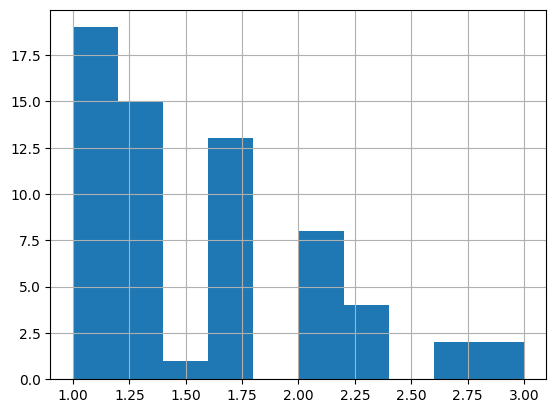

In [19]:
y_test.hist()

In [10]:
# Save model
model_save_path = 'Models/roberta_regressor_2.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to Models/roberta_regressor.pth


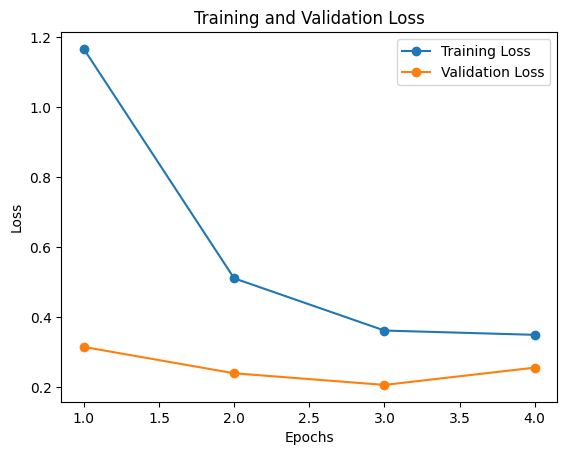

In [7]:
# Assuming train_loss_list and val_loss_list are your lists of loss values
# and num_epochs is the number of epochs
num_epochs = len(train_loss_list)  # Assuming train_loss_list and val_loss_list have the same length
epochs = list(range(1, num_epochs + 1))

# Plotting the training and validation loss
plt.plot(epochs, train_loss_list, label='Training Loss', marker='o')
plt.plot(epochs, val_loss_list, label='Validation Loss', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Example of predicting on new data
new_text = ["The security and freedom of our digital lives is not negotiable. It is time for governments and tech companies to prioritize our online well-being and demonstrate that they truly value the individuals they purport to serve. Our privacy is not for sale - it is a fundamental human right that must be zealously protected."]
encoding = tokenizer(new_text, return_tensors='pt', padding=True, truncation=True, max_length=max_len_tokenizer)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
predicted_value = outputs.squeeze().item()
print(f"Predicted Value: {predicted_value}")

# Grid search attempt

In [4]:
# Define the hyperparameter grid
param_grid = {
    'max_len_tokenizer': [512],
    'num_epochs': [3, 4, 5],
    'batch_size': [4, 8, 16],
    'learning_rate': [1e-5, 1e-6, 1e-7],
}

#'max_len_tokenizer': 128, 'num_epochs': 4, 'batch_size': 16, 'learning_rate': 1e-05}

# Define dataset class
class TextRegressionDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Custom regression head on top of RoBERTa
class RobertaRegression(torch.nn.Module):
    def __init__(self, base_model):
        super(RobertaRegression, self).__init__()
        self.base_model = base_model
        self.regressor = torch.nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]  # CLS token
        return self.regressor(pooled_output)

# Function to train and evaluate the model with given hyperparameters
def train_and_evaluate(max_len_tokenizer, num_epochs, batch_size, learning_rate):
    print(f"Training with max_len={max_len_tokenizer}, epochs={num_epochs}, batch_size={batch_size}, lr={learning_rate}")
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create dataset objects
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    full_train_dataset = TextRegressionDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_len=max_len_tokenizer)
    test_dataset = TextRegressionDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len=max_len_tokenizer)

    # Split the training dataset into training and validation sets
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training setup
    base_model = RobertaModel.from_pretrained('roberta-base')
    model = RobertaRegression(base_model)
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    val_loss_list = []
    train_loss_list = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.squeeze(), targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_loss_list.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['targets'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}, Val Loss: {avg_val_loss}")

    print("######################")

    return min(val_loss_list), model

# Iterate over all combinations of hyperparameters
best_val_loss = float('inf')
best_params = None
best_model = None

for max_len_tokenizer, num_epochs, batch_size, learning_rate in product(*param_grid.values()):
    val_loss, model = train_and_evaluate(max_len_tokenizer, num_epochs, batch_size, learning_rate)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = {
            'max_len_tokenizer': max_len_tokenizer,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate
        }
        best_model = model

print(f"Best hyperparameters: {best_params}")
print(f"Best validation loss: {best_val_loss}")

# Evaluation on the test set with the best model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
test_dataset = TextRegressionDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len=best_params['max_len_tokenizer'])
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
best_model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(targets.tolist())

mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error on test set: {mse}")


Training with max_len=512, epochs=3, batch_size=4, lr=1e-05


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/maxschaffelder/venv/first_venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/3, Loss: 0.6408634744493255, Val Loss: 0.15525274322583124
Epoch 2/3, Loss: 0.26957592441170825, Val Loss: 0.1891056918180906
Epoch 3/3, Loss: 0.24050813694210613, Val Loss: 0.22938628824284443
######################
Training with max_len=512, epochs=3, batch_size=4, lr=1e-06


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 2.502178332969254, Val Loss: 1.8785338722742522
Epoch 2/3, Loss: 1.5502523896740932, Val Loss: 0.7569590531862699
Epoch 3/3, Loss: 0.6681677515015882, Val Loss: 0.27510824914161974
######################
Training with max_len=512, epochs=3, batch_size=4, lr=1e-07


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 3.1865558203528908, Val Loss: 3.414974414385282
Epoch 2/3, Loss: 3.1090555378035005, Val Loss: 3.3273202914458055
Epoch 3/3, Loss: 2.9497905665752935, Val Loss: 3.248062115449172
######################
Training with max_len=512, epochs=3, batch_size=8, lr=1e-05


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: nan, Val Loss: nan
Epoch 2/3, Loss: nan, Val Loss: nan
Epoch 3/3, Loss: nan, Val Loss: nan
######################
Training with max_len=512, epochs=3, batch_size=8, lr=1e-06


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: nan, Val Loss: nan


KeyboardInterrupt: 

Average length in df dataframe: 243.87052551408988
Average length in averaged_df_arg dataframe: 58.09177215189873


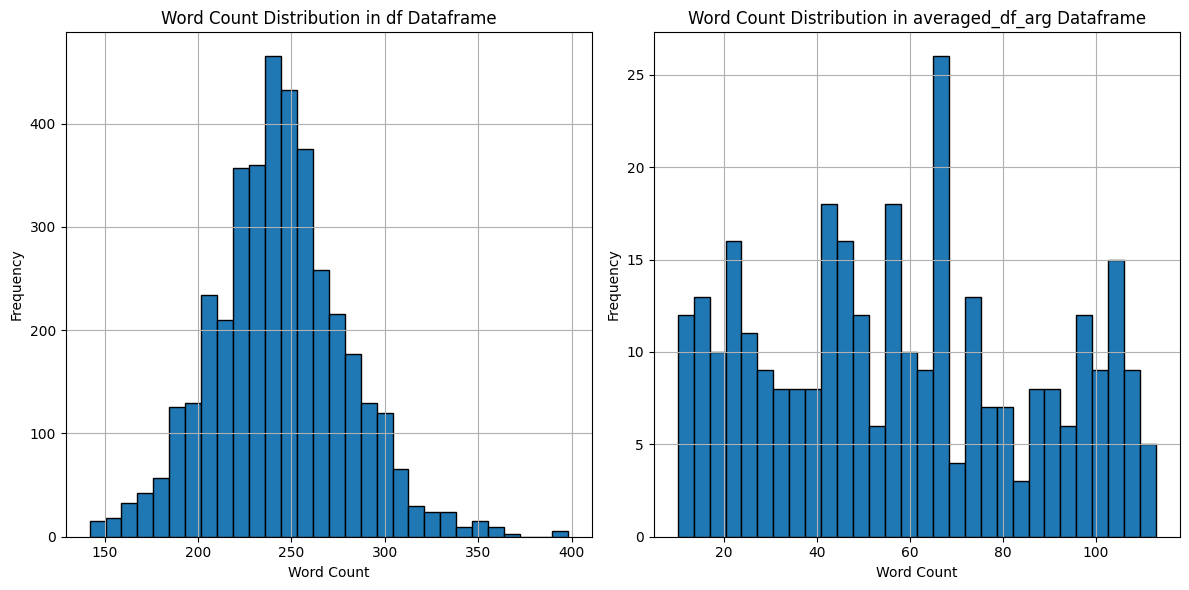

In [7]:
# Calculate the average length in words of entries in the "argument" column of both dataframes

df_persuasion = pd.read_csv("/Users/maxschaffelder/Desktop/Social Computing/Term Project/Code/soc_project/Data/persuasion_data.csv")
df_persuasion_avg_length = df_persuasion['argument'].apply(lambda x: len(x.split())).mean()
averaged_df_arg_avg_length = averaged_df_arg['argument'].apply(lambda x: len(x.split())).mean()

# Print the average lengths
print("Average length in df dataframe:", df_persuasion_avg_length)
print("Average length in averaged_df_arg dataframe:", averaged_df_arg_avg_length)

# Plot the distributions
plt.figure(figsize=(12, 6))

# Distribution for df dataframe
plt.subplot(1, 2, 1)
df_persuasion['argument'].apply(lambda x: len(x.split())).hist(bins=30, edgecolor='black')
plt.title('Word Count Distribution in df Dataframe')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Distribution for averaged_df_arg dataframe
plt.subplot(1, 2, 2)
averaged_df_arg['argument'].apply(lambda x: len(x.split())).hist(bins=30, edgecolor='black')
plt.title('Word Count Distribution in averaged_df_arg Dataframe')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
